In [1]:
from feature_engineering.dao.sussex_huawei_dao import SussexHuaweiDAO
from feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
import matplotlib as plt
import seaborn as sns

In [2]:
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()

In [3]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
labels = dao.read_data(
            '/home/lorenz/PycharmProjects/rctc_pipeline/data_sets/sussex_huawei/User1/220617/Label.txt', #TODO: Pack in config/.env
            column_names=label_column_names, use_columns=[1, 2, 3])
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             #'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             #'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]
data = dao.read_data(
        '/home/lorenz/PycharmProjects/rctc_pipeline/data_sets/sussex_huawei/User1/220617/Bag_Motion.txt', #TODO: Pack in config/.env
        column_names=data_column_names, use_columns=[0,1,2,3,10,11,12,13,14,15,16]) #4,5,6,7,8,9,17,18,19


In [4]:
# 2. Preprocessing

# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='gravity', 
            target_columns = acelerometer_columns,
            support_columns = gravity_columns)

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='orientation', 
            target_columns = acelerometer_columns,
            support_columns = orientation_columns)


#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])

# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 support=selected_coarse_labels)

data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  support=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)
            
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], freq='100ms')
    
# 2.6 Outlier removal:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
        data_segments[ind],
        replacement_mode = 'quantile',
        columns = acelerometer_columns,
        quantile = 0.99
    )
    
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
        data = data_segments[ind],
        mode ='euclidean',
        columns = acelerometer_columns,
        reduced_column_name = 'acceleration_abs'
    )

1


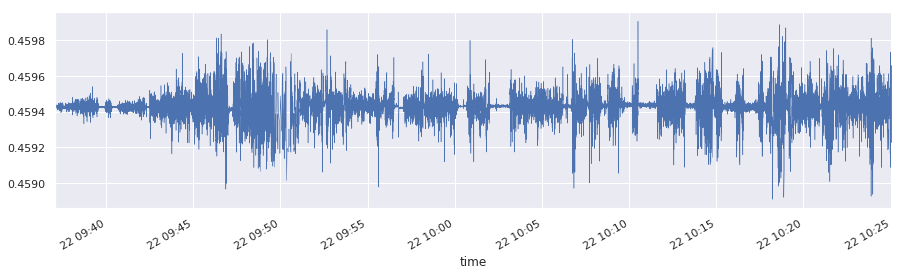

In [5]:

# Visual anlaysis:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[1]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[1]['road_label'].iloc[0]); # 1 = City



3


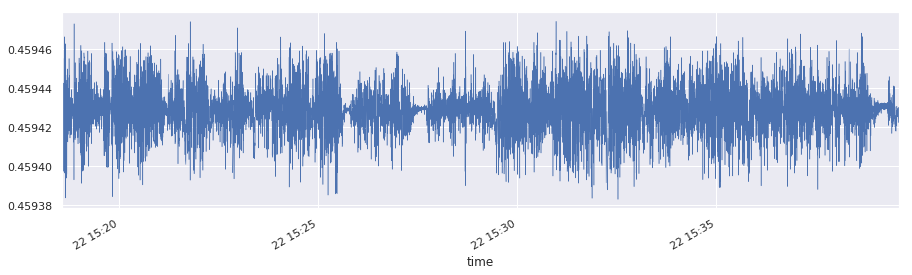

In [6]:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[5]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[5]['road_label'].iloc[0]); # 3 = Country